# Assignment 11

## Question 3

In [7]:
# code frrom the book

from dataclasses import dataclass
from typing import Tuple, Dict
from rl.markov_process import MarkovRewardProcess
from rl.markov_process import FiniteMarkovRewardProcess
from rl.markov_process import RewardTransition
from scipy.stats import poisson
from rl.distribution import SampledDistribution, Categorical
import numpy as np


@dataclass(frozen=True)
class InventoryState:
    on_hand: int
    on_order: int

    def inventory_position(self) -> int:
        return self.on_hand + self.on_order

class SimpleInventoryMRPFinite(FiniteMarkovRewardProcess[InventoryState]):

    def __init__(
        self,
        capacity: int,
        poisson_lambda: float,
        holding_cost: float,
        stockout_cost: float
    ):
        self.capacity: int = capacity
        self.poisson_lambda: float = poisson_lambda
        self.holding_cost: float = holding_cost
        self.stockout_cost: float = stockout_cost

        self.poisson_distr = poisson(poisson_lambda)
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[InventoryState]:
        d: Dict[InventoryState, Categorical[Tuple[InventoryState, float]]] = {}
        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                state = InventoryState(alpha, beta)
                ip = state.inventory_position()
                beta1 = self.capacity - ip
                base_reward = - self.holding_cost * state.on_hand
                sr_probs_map: Dict[Tuple[InventoryState, float], float] =\
                    {(InventoryState(ip - i, beta1), base_reward):
                     self.poisson_distr.pmf(i) for i in range(ip)}
                probability = 1 - self.poisson_distr.cdf(ip - 1)
                reward = base_reward - self.stockout_cost *\
                    (probability * (self.poisson_lambda - ip) +
                     ip * self.poisson_distr.pmf(ip))
                sr_probs_map[(InventoryState(0, beta1), reward)] = probability
                d[state] = Categorical(sr_probs_map)
        return d


if __name__ == '__main__':
    user_capacity = 2
    user_poisson_lambda = 1.0
    user_holding_cost = 1.0
    user_stockout_cost = 10.0

    user_gamma = 0.9

    si_mrp = SimpleInventoryMRPFinite(
        capacity=user_capacity,
        poisson_lambda=user_poisson_lambda,
        holding_cost=user_holding_cost,
        stockout_cost=user_stockout_cost
    )

    from rl.markov_process import FiniteMarkovProcess
    print("Transition Map")
    print("--------------")
    print(FiniteMarkovProcess(si_mrp.transition_map))

    print("Transition Reward Map")
    print("---------------------")
    print(si_mrp)

    print("Stationary Distribution")
    print("-----------------------")
    si_mrp.display_stationary_distribution()
    print()

    print("Reward Function")
    print("---------------")
    si_mrp.display_reward_function()
    print()

    print("Value Function")
    print("--------------")
    si_mrp.display_value_function(gamma=user_gamma)
    print()


Transition Map
--------------
From State InventoryState(on_hand=0, on_order=0):
  To State InventoryState(on_hand=0, on_order=2) with Probability 1.000
From State InventoryState(on_hand=0, on_order=1):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=0, on_order=2):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=0) with Probability 0.264
From State InventoryState(on_hand=1, on_order=0):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=1, on_order=1):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368


In [82]:
# testing the MC prediction algorithm with the above MRP
from rl.monte_carlo import mc_prediction
from rl.function_approx import Tabular

user_tol = 1.e-1

traces = si_mrp.reward_traces(si_mrp.get_stationary_distribution())
vf_iter = mc_prediction(traces,
                        Tabular(),
                        user_gamma)


vf_true = si_mrp.get_value_function_vec(user_gamma)

print("")
n = 0
for vf_mc_tab in vf_iter:    
    if(n == 10000):
        print("\nMC Prediction did not converge before {} it\n".format(n))
        break
    if(all([np.abs(vf_mc_tab.values_map.get(s,0) - vf_true[i]) < user_tol for i,s in enumerate(si_mrp.non_terminal_states)])):
        print("\nMC prediction Converged!\n")
        break
    if(n %100 == 0):
        print("MC prediction at it {}:\n".format(n),[vf_mc_tab.values_map.get(s,0) for s in si_mrp.non_terminal_states])
        
    n += 1

print("True value function:\n", vf_true)


MC prediction at it 0:
 [0, 0, 0, 0, 0, 0]
MC prediction at it 100:
 [-35.41932553389922, -27.995422690638968, -28.252239685270684, -29.151052150084944, -29.456892956474466, -30.61964856826611]
MC prediction at it 200:
 [-35.366280788979076, -27.86373662998384, -28.18473674229434, -28.958889518432134, -29.327876159205918, -30.4043378115302]

MC prediction Converged!

True value function:
 [-35.51060433 -27.93226038 -28.34511593 -28.93226038 -29.34511593
 -30.34511593]


In [93]:
# testing TD prediction algorithm with the above MRP
from rl.td import td_prediction
from rl.function_approx import Tabular

user_tol = 1.e-1

step_stream = si_mrp.simulate_reward(si_mrp.get_stationary_distribution())
vf_iter = td_prediction(step_stream,
                        Tabular(count_to_weight_func = lambda x: 0.1),
                        user_gamma)


vf_true = si_mrp.get_value_function_vec(user_gamma)

print("")
n = 0
for vf_td_tab in vf_iter:    
    if(n == 1000000):
        print("\nTD Prediction did not converge before {} it\n".format(n))
        break
    if(all([np.abs(vf_td_tab.values_map.get(s,0) - vf_true[i]) < user_tol for i,s in enumerate(si_mrp.non_terminal_states)])):
        print("\nTD prediction Converged!\n")
        break
    if(n %5000 == 0):
        print("TD prediction at it {}:\n".format(n),[vf_td_tab.values_map.get(s,0) for s in si_mrp.non_terminal_states])
        
    n += 1

print("True value function:\n", vf_true)


MC prediction at it 0:
 [0, 0, 0, 0, 0, 0]
MC prediction at it 5000:
 [-34.83308046414266, -26.839016370277804, -27.759057166736373, -28.34200347173441, -28.823228325475238, -30.2520554799598]
MC prediction at it 10000:
 [-36.06981786916826, -27.888559830728084, -28.30497185591702, -28.785324258858143, -29.310210303538664, -29.87091220478817]
MC prediction at it 15000:
 [-35.459810910336806, -27.57219769302263, -28.25719824476673, -29.13891247291584, -29.38048850795098, -30.043014817358195]
MC prediction at it 20000:
 [-36.330595879282896, -28.803400206337084, -29.92449448623036, -29.600426072975445, -31.025282267151272, -31.697662581032326]
MC prediction at it 25000:
 [-35.739180675945924, -28.43847227576333, -29.21121980406729, -29.19748262807146, -30.051293816134603, -31.845591594194023]
MC prediction at it 30000:
 [-34.75893846638223, -26.245963415587948, -26.798177801756495, -27.312139307208334, -27.38101074429139, -30.132337403654724]
MC prediction at it 35000:
 [-35.71435582193







## Question 4

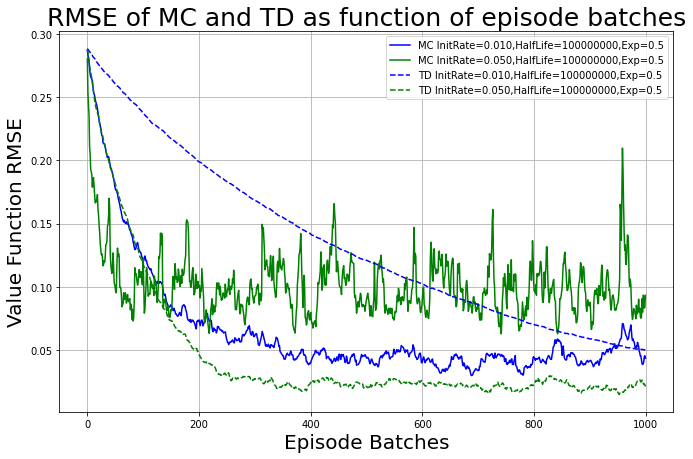

In [8]:
from typing import Mapping, Dict, Optional, Tuple
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess


class RandomWalkMRP2D(FiniteMarkovRewardProcess[int]):
    '''
    This MRP's states are 
    {(i, j) | 0 ≤ i ≤ self.B1, 0 ≤ j ≤ self.B2}
    with (0,j) and (self.B1,j) for all j, 
    and (i,0) and (i,self.B2) for all i as the terminal states.
    At each time step, we either go
    - up with probability self.pu
    - down with probability self.pd,
    - left with probability self.pl, or
    - right with probability self.pr
    The reward is 1 if we transition to a terminal state
    (self.B1,j) for all j or (i,self.B2) for all i, the reward is 0
    for all other states.
    '''
    B1: int
    B2: int
    pu: float
    pd: float
    pr: float
    pl: float

    def __init__(
        self,
        B1: int,
        B2: int,
        pu: float,
        pd: float,
        pr: float,
        pl: float

    ):
        self.B1 = B1
        self.B2 = B2
        assert(pu + pd + pr + pl == 1)
        self.pu = pu
        self.pd = pd
        self.pr = pr
        self.pl = pl
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int, int], Optional[Categorical[Tuple[Tuple[int, int], float]]]]:

        d: Dict[Tuple[int, int], Optional[Categorical[Tuple[Tuple[int, int], float]]]] = {
            (i,j): Categorical({
                ((i, j + 1), 0. if j < self.B2 - 1 else 1.): self.pu,
                ((i, j - 1), 0.): self.pd,
                ((i + 1, j), 0. if i < self.B1 - 1 else 1.): self.pr,
                ((i - 1, j), 0.): self.pl
            }) for i in range(1, self.B1) for j in range(1,self.B2)
        }
        
        for i in range(0, self.B1 + 1):
            d[(i,0)]       = None
            d[(i,self.B2)] = None
        
        for j in range(0, self.B2 + 1):
            d[(0,j)]       = None
            d[(self.B1,j)] = None

        return d


if __name__ == '__main__':
    from rl.chapter10.prediction_utils import compare_td_and_mc

    this_B1: int = 10
    this_B2: int = 10
    this_pu: float = 0.25
    this_pd: float = 0.25
    this_pr: float = 0.25
    this_pl: float = 0.25
    random_walk: RandomWalkMRP2D = RandomWalkMRP2D(
        B1 = this_B1,
        B2 = this_B2,
        pu = this_pu,
        pd = this_pd,
        pr = this_pr,
        pl = this_pl
    )
    compare_td_and_mc(
        fmrp=random_walk,
        gamma=1.0,
        mc_episode_length_tol=1e-6,
        num_episodes=7000,
        learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
        initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
        plot_batch=7,
        plot_start=0
    )
